# Library imports and linking

In [1]:
# installs
!pip install rasterio
!pip install pyshp
!pip install utm

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10, sqrt

# image processing
import cv2
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola, threshold_local)
from skimage.morphology import skeletonize
from PIL import Image
import colorsys

!pip install PyMaxflow
import maxflow 

# metrics
from sklearn.metrics import f1_score
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score
from sklearn.metrics import r2_score

# georeferencing
import rasterio as rt
from rasterio.enums import Resampling
import shapefile
import utm

THETA = math.pi/180

In [3]:
!pip install gdal

You should consider upgrading via the 'C:\Users\adeju\anaconda3\envs\tensorflow-cpu\python.exe -m pip install --upgrade pip' command.


# Functions and definitions

In [2]:
def load_image(file, scale):
    dataset = rt.open(file)

    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale),
            int(dataset.width * scale)
        ),
        resampling=Resampling.bilinear
    )

    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    image = np.moveaxis(data, 0, -1)
    crs = dataset.profile['crs']
    width = np.shape(image)[1]
    height = np.shape(image)[0]
    count = np.shape(image)[2]

    new_dataset = rt.open("temp.tif", 'w', driver='GTiff',
                          height=height, width=width,
                          count=count, dtype=str(image.dtype),
                          crs=crs,
                          transform=transform)

    return image, new_dataset

def save_image(image, file, crs, transform):
    width = np.shape(image)[1]
    height = np.shape(image)[0]

    try:
        count = np.shape(image)[2]
        array = np.moveaxis(image, 2, 0)
    except Exception:
        count = 1
        array = np.reshape(image, (1, np.shape(image)[0],
                                   np.shape(image)[1]))

    new_dataset = rt.open(file, 'w', driver='GTiff',
                          height=height, width=width,
                          count=count, dtype=str(array.dtype),
                          crs=crs,
                          transform=transform)

    new_dataset.write(array)
    new_dataset.close()

    return

def save_shapefile(file_address, regression_lines, segm_group_angles, dataset):
    '''
    Save line segments to shapefiles.

    Parameters
    ----------
    file_address : String
        DESCRIPTION.
    regression_lines : Array of int64
        Array of line segments.
    segm_group_angles : Array of int64
        Array of angles and line lengths.
    dataset : Object
        Rasterio object.

    Returns
    -------
    None.

    '''
    w = shapefile.Writer(file_address, shapeType=3)
    w.field('fracture_i', 'N')
    w.field('fractdir', 'N')
    w.field('fractlength', 'N')

    for i in range(0, np.shape(regression_lines)[0]):
        point0 = dataset.xy(regression_lines[i, 1], regression_lines[i, 0])
        point1 = dataset.xy(regression_lines[i, 3], regression_lines[i, 2])
        # Add record
        w.record(i, segm_group_angles[i, 0], 0)
        # Add geometry
        w.line([[[point0[0], point0[1]], [point1[0], point1[1]]]])

    w.close()
    return

In [66]:
def utm_distance_to_pixel(dataset, distance):
  if dataset.crs != 'None':
    position_utm = np.asarray(utm.from_latlon(dataset.bounds.left,
                                              dataset.bounds.top))
    position = utm.to_latlon(float(position_utm[0]),
                              float(position_utm[1]) + distance,
                              int(position_utm[2]), position_utm[3])
    row, col = dataset.index(position[0], position[1])

    '''
    dataset = rt.open('lajedo4.tif')

    inicio = utm.from_latlon(dataset.xy(0,0)[0], dataset.xy(0,0)[1])
    fim = utm.from_latlon(dataset.xy(0,60)[0], dataset.xy(0,60)[1])

    print(frac.compute_distance(inicio[0], inicio[1] , fim[0], fim[1]))
    '''

    distance = int(compute_distance(0, 0, row, col))

  return distance

def coordinate_to_pixel_position(map_position, dataset):
    if np.size(map_position) == 3:  # UTM coordinates
        try:
            lat, lon = utm.to_latlon(map_position[0], map_position[1],
                                     map_position[2], northern=False)
            image_position = dataset.index(lon, lat)
        except Exception as e:
            print(e)
            return False
    elif np.size(map_position) == 2:  # WGS84 coordinates
        image_position = dataset.index(map_position[1], map_position[0])
    else:
        return False
    return image_position


def destination_point(lat1, lon1, distance, bearing, radius=6371000):
    '''
      distance is the distance we want to travel from a point
      bearing is the angle in relation to north
    '''

    angDist = distance / radius  # angular distance in radians
    bearing = math.radians(bearing)

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)

    lat2sin = math.sin(lat1) * math.cos(angDist) + math.cos(lat1) * math.sin(
        angDist) * math.cos(bearing)
    lat2 = math.asin(lat2sin)
    y = math.sin(bearing) * math.sin(angDist) * math.cos(lat1)
    x = math.cos(angDist) - math.sin(lat1) * lat2sin
    lon2 = lon1 + math.atan2(y, x)

    lat = math.degrees(lat2)
    lon = math.degrees(lon2)

    return (lat, lon)

In [4]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [5]:
def threshold_phansalkar(image, window_size=15, k=0.5, R=128, p=3, q=0.4):
  if window_size % 2 == 0:  # Exit function if kernel is even
    return

  offset = int(window_size/2)  # Pixels for each side around a kernel center
  new_image = np.zeros(np.shape(image))  # Thresholded image

  for i in range(0, np.shape(image)[1]):  # collumn
    for j in range(0, np.shape(image)[0]):  # row
      # Create and change offsets for each direction according to (i,j)
      # position near the limits of the image
      offsetL = offsetR = offsetU = offsetD = offset
      if j <= offset:
        offsetL = offset + (j - offset)
      if np.shape(image)[0] - j <= offset:
        offsetR = np.shape(image)[0] - j
      if i <= offset:
        offsetU = offset + (i - offset)
      if np.shape(image)[1] - i <= offset:
        offsetD = np.shape(image)[1] - i

      # Store in memory (temp) the kernel for (i,j) position
      temp = image[j-offsetL:j+offsetR+1, i-offsetU:i+offsetD+1]

      T = np.mean(temp)*(1 + p * np.exp(-q * np.mean(temp)) + k*((np.std(temp)/R) - 1))
      new_image[j, i] = T

  return  new_image

In [6]:
# from skimage.filters import 

def threshold_phansalkar2(image, window_size=15, k=0.2, r=0.5):
    """Applies Sauvola local threshold to an array. Sauvola is a
    modification of Niblack technique.
    In the original method a threshold T is calculated for every pixel
    in the image using the following formula::
        T = m(x,y) * (1 + k * ((s(x,y) / R) - 1))
    where m(x,y) and s(x,y) are the mean and standard deviation of
    pixel (x,y) neighborhood defined by a rectangular window with size w
    times w centered around the pixel. k is a configurable parameter
    that weights the effect of standard deviation.
    R is the maximum standard deviation of a grayscale image.
    Parameters
    ----------
    image : (N, M[, ..., P]) ndarray
        Grayscale input image.
    window_size : int, or iterable of int, optional
        Window size specified as a single odd integer (3, 5, 7, …),
        or an iterable of length ``image.ndim`` containing only odd
        integers (e.g. ``(1, 5, 5)``).
    k : float, optional
        Value of the positive parameter k.
    r : float, optional
        Value of R, the dynamic range of standard deviation.
        If None, set to the half of the image dtype range.
    Returns
    -------
    threshold : (N, M) ndarray
        Threshold mask. All pixels with an intensity higher than
        this value are assumed to be foreground.
    Notes
    -----
    This algorithm is originally designed for text recognition.
    References
    ----------
    .. [1] J. Sauvola and M. Pietikainen, "Adaptive document image
           binarization," Pattern Recognition 33(2),
           pp. 225-236, 2000.
           :DOI:`10.1016/S0031-3203(99)00055-2`
    Examples
    --------
    >>> from skimage import data
    >>> image = data.page()
    >>> t_sauvola = threshold_sauvola(image, window_size=15, k=0.2)
    >>> binary_image = image > t_sauvola
    """
    if r is None:
        imin, imax = dtype_limits(image, clip_negative=False)
        r = 0.5 * (imax - imin)
    m, s = _mean_std(image, window_size)
    return m * (1 + k * ((s / r) - 1))

In [7]:
def adaptative_thresholding(image, kernelsize, k=0.5, R=128, mode='sauvola'):
    if kernelsize % 2 == 0:  # Exit function if kernel is even
        return

    offset = int(kernelsize/2)  # Pixels for each side around a kernel center

    new_image = np.zeros(np.shape(image))  # Thresholded image

    for i in range(0, np.shape(image)[1]):  # collumn
        for j in range(0, np.shape(image)[0]):  # row

            # Create and change offsets for each direction according to (i,j)
            # position near the limits of the image
            offsetL = offsetR = offsetU = offsetD = offset
            if j <= offset:
                offsetL = offset + (j - offset)
            if np.shape(image)[0] - j <= offset:
                offsetR = np.shape(image)[0] - j
            if i <= offset:
                offsetU = offset + (i - offset)
            if np.shape(image)[1] - i <= offset:
                offsetD = np.shape(image)[1] - i

            # Store in memory (temp) the kernel for (i,j) position
            temp = image[j-offsetL:j+offsetR+1, i-offsetU:i+offsetD+1]

            # Apply thresholding method
            if mode == 'niblack':
                T = int(np.mean(temp) + k*np.std(temp))
                new_image[j, i] = T
            if mode == 'sauvola':
                T = int(np.mean(temp)*(1 + k*(np.std(temp)/R - 1)))
                new_image[j, i] = T
            if mode == 'pca':
                temp = np.reshape(temp, (-1,1))
                temp = np.concatenate((np.reshape(list(range(np.size(temp))), (-1,1)), temp.tolist()), axis=1)

                pca = PCA(n_components=1, svd_solver='full')
                pca.fit(temp)

                X_pca = pca.transform(temp)
                X_new = pca.inverse_transform(X_pca)
                T = int(X_new[int(kernelsize/2)][1])

                new_image[j, i] = T

    return new_image

In [8]:
def print_lines(image, lines, color):
    # output = np.full(np.shape(image), 0, dtype=np.uint8)
    for i in range(0,np.shape(lines)[0]):
        image = cv2.line(image, (lines[i][0][0],lines[i][0][1]), (lines[i][0][2],lines[i][0][3]), color, 4)
    return image

In [9]:
def compute_distance(x0, y0, x1, y1):
    '''
    Compute the distance between two point.

    Parameters
    ----------
    x0 : TYPE
        DESCRIPTION.
    y0 : TYPE
        DESCRIPTION.
    x1 : TYPE
        DESCRIPTION.
    y1 : TYPE
        DESCRIPTION.

    Returns
    -------
    dist : float
        Distance in pixel size.

    '''

    dist = math.sqrt(math.pow((x1 - x0), 2) + math.pow((y1 - y0), 2))
    return dist


def get_line_angles(lines):
    '''
    Get distance and angle of all lines regarding north

    Parameters
    ----------
    lines : Array of int64
        Array with structure [[Px Py Qx Qy] ... [Px Py Qx Qy]].

    Returns
    -------
    angles : Array of float64
        Array with angle and length for each line.

    '''
    # Get distance and angle of all lines regarding north
    n = np.shape(lines)[0]
    angles = np.zeros((n, 2), np.float64)
    for i in range(0, n):
        length = compute_distance(lines[i][0], lines[i][1], lines[i][2],
                                  lines[i][3])

        if lines[i][1] == lines[i][3]:
            angle = 90
        else:
            angle = (math.atan((lines[i][2]-lines[i][0])
                               / (lines[i][1]-lines[i][3])) / (THETA))

        if (angle < 0):
            angle = angle + 360
        if (angle > 180):
            angle = angle - 180
        if math.isnan(angle):
            angle = 0

        angles[i, 0] = np.uint8(angle)
        angles[i, 1] = length
    return angles


def compare_angles(base, line1, line2):
    '''
    Measure the angle between two lines or segments given a reference vertex.
    Extends the closest point on line2 to the base point on line1 to measure
    the angle.

    Parameters
    ----------
    base : list
        Vertex on line1 used as reference to obtain the angle.
    line1 : list
        First line or segment.
    line2 : list
        Second line or segment.

    Returns
    -------
    angle : float
        Angle in degrees.
    distance : float
        Distance to the closest point on line2 to the base point.
    x : int
        X position of the closest point on line2.
    y : int
        Y position of the closest point on line2.

    '''
    x0, y0 = base
    if [line1[0], line1[1]] == [x0, y0]:
        px, py = [line1[2], line1[3]]
    else:
        px, py = [line1[0], line1[1]]

    dist0 = compute_distance(x0, y0, line2[0], line2[1])
    dist1 = compute_distance(x0, y0, line2[2], line2[3])

    if dist0 < dist1:
        px = px - x0
        py = py - y0
        qx, qy = [float(line2[2]) - x0, float(line2[3]) - y0]
        aux = ((px*qx) + (py*qy))/(math.sqrt(
            math.pow(px, 2) + math.pow(py, 2))*math.sqrt(math.pow(qx, 2) +
                                                         math.pow(qy, 2)))
        try:
            angle = math.acos(aux)*180/math.pi
        except Exception:
            if (aux) > 0:
                angle = 0
            if (aux) < 0:
                angle = 180
        return (angle, dist0, line2[0], line2[1])
    else:
        px = px - x0
        py = py - y0
        qx, qy = [line2[0] - x0, line2[1] - y0]
        aux = ((px*qx) + (py*qy))/(math.sqrt(
            math.pow(px, 2) + math.pow(py, 2))*math.sqrt(math.pow(qx, 2) +
                                                         math.pow(qy, 2)))
        try:
            angle = math.acos(aux)*180/math.pi
        except Exception:
            if (aux) > 0:
                angle = 0
            if (aux) < 0:
                angle = 180
        return (angle, dist1, line2[2], line2[3])


# Helper function for line intersection on function find_intersection**********

def on_segment(p, q, r):
    # Check if segments have points overlapping in the same direction
    if (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y)):
        return 1
    return 0


def intersection(p, q, r):
    # Check if segments cross each other
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x)*(r.y - q.y)
    if val == 0:
        return 0
    if val > 0:
        return 1
    else:
        return 2


def do_intersect(p1, q1, p2, q2):
    # Check if segments intersect (cross or overlap)
    o1 = intersection(p1, q1, p2)
    o2 = intersection(p1, q1, q2)
    o3 = intersection(p2, q2, p1)
    o4 = intersection(p2, q2, q1)

    if (o1 != o2 and o3 != o4):
        return True
    if (o1 == 0 and on_segment(p1, p2, q1)):
        return True
    if (o2 == 0 and on_segment(p1, q2, q1)):
        return True
    if (o3 == 0 and on_segment(p2, p1, q2)):
        return True
    if (o4 == 0 and on_segment(p2, q1, q2)):
        return True
    return False


class Point:
    # Class for points
    x = None
    y = None

    def __init__(self, v1, v2):
        self.x = v1
        self.y = v2


def find_intersection(line1, line2):
    '''
    Receives two line segments and returns the crossing point if exists

    Parameters
    ----------
    line1 : list
        Two xy coordinates in a list of four itens.
    line2 : TYPE
        Two xy coordinates in a list of four itens.

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''

    x0, y0, x1, y1 = line1
    x2, y2, x3, y3 = line2

    if do_intersect(
            Point(x0, y0), Point(x1, y1), Point(x2, y2),
            Point(x3, y3)) == False:
        return False

    try:
        denom = float((x0 - x1) * (y2 - y3) - (y0 - y1) * (x2 - x3))
        x = ((x0 * y1 - y0 * x1) * (x2 - x3) -
             (x0 - x1) * (x2 * y3 - y2 * x3)) / denom
        y = ((x0 * y1 - y0 * x1) * (y2 - y3) -
             (y0 - y1) * (x2 * y3 - y2 * x3)) / denom
    except ZeroDivisionError:
        return False
    return [x, y]

def bresenham_march(image, line_segment):
    '''
    Line iterator substituting opencv removed implementation

    Parameters
    ----------
    image : Array of uint8
        Grayscale image.
    p1 : list
        x and y coordinates of first point.
    p2 : list
        x and y coordinates of first point.

    Returns
    -------
    ret : list
        List of pixel intensities for the given segment.

    '''
    x1, y1, x2, y2 = np.int64(line_segment)
    discrete_line = line_segment(x1, y1, x2, y2)

    return image[discrete_line[1], discrete_line[0]]

# def connect_lines(lines, angles, window_size, alpha_limit, beta_limit):
#   vertices = np.reshape(lines, (int(np.size(lines)/2), 2))
#   line_indexes = np.uint64(np.arange(0, np.shape(lines)[0], 0.5))

#   candidate_line = []

#   for i in range(0,np.shape(vertices)[0]):
#     for j in range(0,np.shape(vertices)[0]):
#       if line_indexes[i] != line_indexes[j]:
#         dist = compute_distance(vertices[i,0],vertices[i,1], vertices[j,0],vertices[j,1])

#         if dist <= window_size:
#           if str(np.sort((i, j))) not in candidate_line:
#             candidate_line.append(str(np.sort((i, j))))

#   candidate_line = np.reshape([np.fromstring(element[1:-1], sep=' ').astype(int)
#                     for element in candidate_line], (np.size(candidate_line), 2))
  
#   for i, j in candidate_line:
#     print(lines[line_indexes[i]], lines[line_indexes[j]])
#     print(compare_angles((vertices[i,0], vertices[i,0]), lines[line_indexes[i]], lines[line_indexes[j]]))
#     print(compute_distance(vertices[i,0],vertices[i,1], vertices[j,0],vertices[j,1]))

#   return candidate_line


# lines = np.reshape(lines, (np.shape(lines)[0], 4))
# lines = np.int64(lines)
# angles = get_line_angles(lines)
# new_lines = connect_lines(lines, angles, 50, 90, 90)

In [10]:
def image_to_graph(image):
    # image = np.zeros((500, 500, 3))
    image_width = np.shape(image)[0]
    image_height = np.shape(image)[1]

    idx = np.reshape(list(range(image_width*image_height)),
                     (np.shape(image)[0], np.shape(image)[1]))
    I = []
    A = []
    positions = []

    for x in range(image_width):
        for y in range(image_height):
            positions.append((x, y))
            I.append(image[x, y])

            aux = []

            if y != 0:
                up = idx[x, y-1]
                aux.append(up)

            if y != 0:
                ul = idx[x-1, y-1]
                aux.append(ul)

            if y != 0 and x != image_width-1:
                ur = idx[x+1, y-1]
                aux.append(ur)

            if y != image_height-1:
                down = idx[x, y+1]
                aux.append(down)

            if y != image_height-1:
                dl = idx[x-1, y+1]
                aux.append(dl)

            if y != image_height-1 and x != image_width-1:
                dr = idx[x+1, y+1]
                aux.append(dr)

            if x != 0:
                left = idx[x-1, y]
                aux.append(left)

            if x != image_width-1:
                right = idx[x+1, y]
                aux.append(right)
            A.append(aux)
            del(aux)

    return I, A, positions, idx


def region_growing(I, A, seed, ref, size, visited = []):
    #visited = np.full((size), False)
    # seed = 405621
    # ref = '[  0   0   0 255]'
    
    #visited = []

    queue = []
    queue.append(seed)
    # visited[seed] = True

    backtrack = []
    backtrack.append(seed)

    while queue:  # queue
        s = queue.pop(0)
        # print("Pop " + str(s))
        temp = A[s]
        for k in temp:
            # if visited[s] == False:
            if str(I[k]) == ref:
                # if visited[k] == False:
                if k not in visited:
                    queue.append(k)
                    backtrack.append(k)
                visited.append(k)
    return backtrack

def search_dictionary(dict, value):
    for key in dict.keys():
        if value in dict[key]:
            return key
# Detect terminations and fracture connections_________________________________


def line_detection(onepixel):

  count = 0
  terminations = []
  nodes = []
  for i in range(1, np.shape(onepixel)[0]):
      for j in range(1, np.shape(onepixel)[1]):
          temp = onepixel[i-2:i+1, j-2:j+1]
          count += 1
          if np.size(temp) == 9 and temp[1, 1] == 255 and np.sum(temp) == 510:
              terminations.append((i-1, j-1))
          if np.size(temp) == 9 and temp[1, 1] == 255 and np.sum(temp) > 765:
              nodes.append((i-1, j-1))


  # Mark the identified nodes in an image
  whiteboard = np.full((np.shape(onepixel)[0], np.shape(onepixel)[1], 4),
                      0, dtype=np.uint8)
  # whiteboard = np.copy(onepixel)
  whiteboard[:, :, 3] = onepixel

  for i, j in nodes:
      whiteboard[i, j] = (255, 0, 0, 255)
      # whiteboard = cv2.circle(whiteboard, (j, i), 3, (255, 0, 0, 255))

  for i, j in terminations:
      whiteboard[i, j] = (0, 255, 0, 255)
      # whiteboard = cv2.circle(whiteboard, (j, i), 3, (255, 0, 0, 255))


  # Map whiteboard to graph
  I, A, positions, idx_map = image_to_graph(whiteboard)

  # Vectorize segments from terminations
  count = 0
  segments = []
  visited = []
  size = np.size(A)
  for i in terminations:
      seed = idx_map[i]
      backtrack = region_growing(I, A, seed, '[  0   0   0 255]', size, visited)
      if np.size(backtrack) > 1:
          segments.append(backtrack)
          # for i in backtrack:
          #     whiteboard[positions[i]] = (0, 255, 255, 255)

  endnodes = np.size(segments)

  # Vectorize segments from X and Y nodes
  for i in nodes:
      k, l = i
      seeds = list(idx_map[k-1:k+2, l-1:l+2].flatten())
      seeds.remove(idx_map[k,l])

      # seed = idx_map[i]
      for seed in seeds:
          backtrack = region_growing(I, A, seed, '[  0   0   0 255]', size, visited)
          # print(np.size(backtrack))
          if np.size(backtrack) > 1:
              segments.append(backtrack)

  # Get traced line between endpoint segments
  lines = []
  for pixel_idx in segments:
      y0, x0 = positions[pixel_idx[0]]
      y1, x1 = positions[pixel_idx[-1]]
      lines.append((x0, y0, x1, y1))
  lines = np.reshape(lines, (np.shape(lines)[0], 4))

  return lines

In [11]:
def rosechart(angles_, weights=None):

  # angles = segm_group_angles[:, 0]
  bin_edges = np.arange(-5, 366, 10)
  number_of_strikes, bin_edges = np.histogram(angles_, bin_edges, weights)

  number_of_strikes[0] += number_of_strikes[-1]

  half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
  two_halves = np.concatenate([half, half])

  fig = plt.figure() # figsize=(10, 10)
  ax = fig.add_subplot(111, projection='polar')

  ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
          width=np.deg2rad(10), bottom=0.0, color='purple', edgecolor='k')
  ax.set_theta_zero_location('N')
  ax.set_theta_direction(-1)
  ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
  # ax.set_rgrids(np.arange(1, two_halves.max()+1, 2),angle=0,weight='black')
  ax.set_title("N = "+str(np.size(angles_)), y=1.10, fontsize=25)
  # plt.show()
  # fig.tight_layout()
  # fig.canvas.draw()

  # # Now we can save it to a numpy array.
  # plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  # plot = plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  plt.show()

In [12]:
def compute_p_statistics(lines, threshold, boxsize):
    data = []
    # boxsize = 20
    # lines = connected_lines
    # check = np.zeros((np.shape(lines)[0]+1), dtype=bool)
    maxH = int(np.shape(threshold)[0]/boxsize)+1
    maxV = int(np.shape(threshold)[1]/boxsize)+1

    def checkArea(x0, x1, y0, y1, lines, k):
        count = 0
        vertices = []

        # Check if line is inside the area
        if lines[k][0] > x0 and lines[k][0] < x1 and lines[k][1] > y0 and lines[k][1] < y1:
            vertices.append(lines[k][0])
            vertices.append(lines[k][1])
            count = count + 1
        if lines[k][2] > x0 and lines[k][2] < x1 and lines[k][3] > y0 and lines[k][3] < y1:
            vertices.append(lines[k][2])
            vertices.append(lines[k][3])
            count = count + 1

        # Check if the line crosses the area border
        intersection = find_intersection([x0, y0, x1, y0], lines[k])
        if intersection != False and math.isnan(intersection[0]) == False:
            count = count + 1
            vertices.append(intersection[0])
            vertices.append(intersection[1])


        intersection = find_intersection([x1, y0, x1, y1], lines[k])
        if intersection != False and math.isnan(intersection[0]) == False:
            count = count + 1
            vertices.append(intersection[0])
            vertices.append(intersection[1])

        intersection = find_intersection([x0, y1, x1, y1], lines[k])
        if intersection != False and math.isnan(intersection[0]) == False:
            count = count + 1
            vertices.append(intersection[0])
            vertices.append(intersection[1])

        intersection = find_intersection([x0, y1, x0, y0], lines[k])
        if intersection != False and math.isnan(intersection[0]) == False:
            count = count + 1
            vertices.append(intersection[0])
            vertices.append(intersection[1])

        if count > 2:
            print(vertices)

        if count >= 2:
            return np.reshape(vertices[0:4], (4, 1))
        else:
            return False

    for i in range(0, maxV):
        for j in range(0, maxH):
            x0 = float(i*boxsize)
            x1 = float((i+1)*boxsize)
            y0 = float(j*boxsize)
            y1 = float((j+1)*boxsize)
            box = []
            for k in range(0, np.shape(lines)[0]):
                line = checkArea(x0, x1, y0, y1, lines, k)
                if np.size(line) == 4:
                    # print(line)
                    box.append(line)

            total_length = 0
            length = []
            for row in box:
                length_line = compute_distance(row[0], row[1], row[2], row[3])
                if math.isnan(length_line): print(row[0], row[1], row[2], row[3])
                length.append(length_line)
                # if length_line > 1:
                total_length += length_line

            intensity_line = total_length/np.power(boxsize, 2)
            spacing_area = np.power(boxsize, 2)/(boxsize + total_length)

            if intensity_line > 0.23:
                print(i, j, length)

            intensity_line = np.reshape(intensity_line, (1))[0]
            spacing_area = np.reshape(spacing_area, (1))[0]

            data.append(np.reshape((x0, y0, x1, y1,
                                    intensity_line, spacing_area), (1, 6)))
    data = np.reshape(data, (np.shape(data)[0], 6))
    return data

In [13]:
def draw_intensity_map(data, canvas, mode='raster', index='intensity', lines=None):
    max_value = np.max(data[:,4])
    # index = 'spacing'
    # max_value = 20
    if mode == 'raster':
        canvas = np.full((np.shape(canvas)[0], np.shape(canvas)[1], 3), 255,
                         dtype=np.uint8)

    for row in data:
        if row[4] == 0.0 and index == 'intensity':
            color = (0, 255, 178)
            #color = (255, 255, 255)
        elif row[5] == max_value and index == 'spacing':
            color = (0, 102, 255)

        else:
            if index == 'intensity':
                color = colorsys.hsv_to_rgb((0.45+row[4]/max_value*0.20), 1, 1)
                color = (int(color[0]*255), int(color[1]*255), int(color[2]
                                                                   * 255))
            elif index == 'spacing':
                color = colorsys.hsv_to_rgb((0.45+row[5]/max_value*0.20), 1, 1)
                color = (int(color[0]*255), int(color[1]*255), int(color[2]
                                                                   * 255))
            elif index == 'intensity_area':
                color = colorsys.hsv_to_rgb((0.45+row[6]*0.20), 1, 1)
                color = (int(color[0]*255), int(color[1]*255), int(color[2]
                                                                   * 255))
            else:
                color = (0, 0, 0)

        if mode == 'svg':
            canvas.add(canvas.rect((row[0], row[1]), (20, 20),
                                   fill=svgwrite.rgb(int(color[2]),
                                                     int(color[1]),
                                                     int(color[0]), 'RGB')))
            # canvas.add(canvas.text(str(round(row[4], 2)),
            #                        insert=(row[0]+2, row[1]+15),
            #                        stroke='none',
            #                        fill=svgwrite.rgb(15, 15, 15, '%'),
            #                        font_size='9px', font_weight="bold"))
        elif mode == 'raster':
            canvas = cv2.rectangle(canvas, (int(row[0]), int(row[1])),
                                   (int(row[2]), int(row[3])), color, -1)
            #canvas = cv2.putText(canvas, "{:5.2f}".format(row[4]),
            #                     (int(row[0]), int(row[1])+10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0,0,0), 1)
            
    if type(lines) == np.ndarray:
        for i in range(0, np.shape(lines)[0]):
        # color = colorsys.hsv_to_rgb(angles[i][0]/180,1,1)
        # color = (color[0]*255, color[1]*255, color[2]*255)
            if mode == 'svg':
                dwg.add(dwg.line(start=(lines[i][0], lines[i][1]),
                                end=(lines[i][2], lines[i][3]),
                                stroke=svgwrite.rgb(10, 10, 16, '%'),
                                stroke_width=0.5))
            if mode == 'raster':
                for i in range(np.shape(lines)[0]):
                    canvas = cv2.line(canvas, (int(lines[i][0]), int(lines[i][1])),
                                      (int(lines[i][2]), int(lines[i][3])),
                                      (0, 0, 0), 1)
    # frac.show_image(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    # frac.show_image(canvas)
    return canvas

In [14]:
def inverse_cumulative_powerlaw(bins, alpha, cumulative=True):
    power_law = ((alpha-1)/(np.min(bins))*np.power(
        (bins/np.min(bins)), -alpha))
    if cumulative is True:
        power_law = power_law.cumsum()
        power_law /= power_law[-1]
    return power_law


def inverse_cumulative_lognormal(bins, mu, sigma, cumulative=True):
    log_normal = (1/(bins*sigma*np.sqrt(2 * np.pi))*np.exp(
        -np.power((np.log(bins)-mu), 2) / (2*np.power(sigma, 2))))
    if cumulative is True:
        log_normal = log_normal.cumsum()
        log_normal /= log_normal[-1]
    return log_normal


def inverse_cumulative_exponential(bins, A, cumulative=True):
    distribution = A*np.exp(-bins/bins[0])
    distribution = 1/np.mean(bins)*np.exp(1/np.mean(bins)*bins)
    if cumulative is True:
        distribution = distribution.cumsum()
        distribution /= distribution[-1]
    return distribution


def probability_plot(data, distribution_type, title, xlabel, alpha=None, A=None):
    # title = ''
    # distribution_type = 'gwer'
    # data = segm_group_angles[:,1]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(True)

    X = np.flip(np.sort(data))
    uniform_data = np.linspace(min(data), max(data), np.size(data))  # np.sort(data)
    if distribution_type == 'power':
        Y = inverse_cumulative_powerlaw(uniform_data, alpha)
    elif distribution_type == 'lognormal':
        mu = np.mean(data)
        sigma = np.std(data)
        Y = inverse_cumulative_lognormal(uniform_data, mu, sigma)
    elif distribution_type == 'exponential':
        Y = inverse_cumulative_exponential(uniform_data, A, cumulative=True)

    Y = np.reshape(Y, (np.size(Y), 1))
    A = np.vstack([X, np.ones(np.size(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]
    ax.plot(X, Y, 'bx', label="Data")
    ax.plot(X, (m*X+c), 'r--', label="Least Squares")
    r2 = r2_score(Y, m*X+c)
    ax.plot([], [], ' ', label="R2 score: " + str("%.3f" % round(r2, 3)))
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Cumulative distribution function", fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return Y

In [15]:
def compute_fractal_dimension(data): # Rizzo, 2017. pag 19
    alpha = 1 + np.size(data)*np.power(abs(np.sum(np.log(data/np.min(data)))), -1)
    return alpha
#alpha1 = compute_fractal_dimension(set1[:, 1])
#print(alpha1)
# TODO: Use SGD to get optmize value for fractal dimension alpha (D) 

In [16]:
def graph_cut(img, smoothing):
    # Load the image and convert it to grayscale image 
    # image_path = 'your_image.png'
    # img = cv2.imread('image_path')
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = 255 * (img > 128).astype(np.uint8)
    img = binarized*255

    # Create the graph.
    g = maxflow.Graph[int]()
    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    nodeids = g.add_grid_nodes(img.shape)
    # Add non-terminal edges with the same capacity.
    g.add_grid_edges(nodeids, smoothing)
    # Add the terminal edges. The image pixels are the capacities
    # of the edges from the source node. The inverted image pixels
    # are the capacities of the edges to the sink node.
    g.add_grid_tedges(nodeids, img, 255-img)

    # Find the maximum flow.
    g.maxflow()
    # Get the segments of the nodes in the grid.
    sgm = g.get_grid_segments(nodeids)

    # The labels should be 1 where sgm is False and 0 otherwise.
    img_denoised = np.logical_not(sgm).astype(np.uint8) * 255
    return img_denoised

# Evaluating Adaptive thresholding methods

## Loading Images

In [18]:
# image = cv2.imread("jandaira.tif")
image, dataset = load_image('jandaira.tif', 1)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ground_truth = cv2.imread("jandaira_annotated.png")
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
ground_truth = np.asarray(ground_truth/255, dtype=bool)

### Show Reference images

D:\Conda_envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


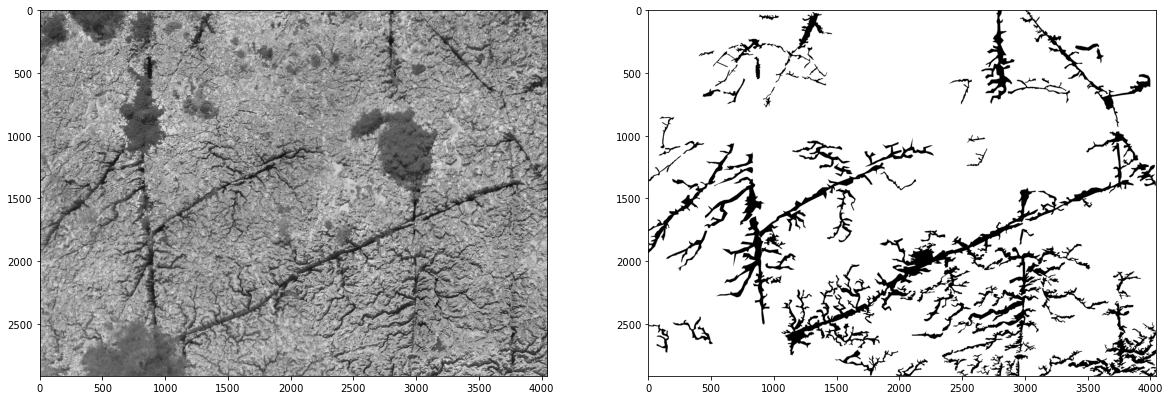

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].imshow(grayscale, cmap='gray')
axs[1].imshow(ground_truth, cmap='gray')
fig.show()

### Test image processing enhancements

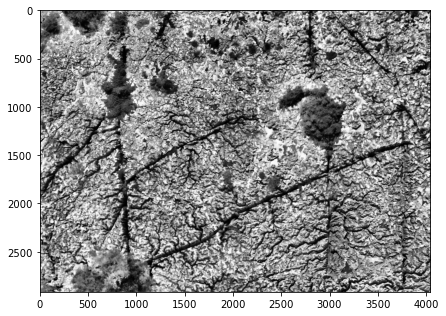

In [31]:
clahe = cv2.createCLAHE(clipLimit = 40)
enhanced = clahe.apply(grayscale)
blur = cv2.bilateralFilter(enhanced,9,75,75)
blur = cv2.medianBlur(enhanced, 9)
plt.figure(figsize=(7,7))
plt.imshow(blur, cmap='gray')

## Testing thresholdig methods

In [37]:
def evaluate_segmentation(binarized, ground_truth):
    print("mIoU: " + str(jaccard_score(ground_truth, binarized, average='micro')))
    print("SSIM: " + str(ssim(ground_truth, binarized)))
    print("F1: " + str(f1_score(ground_truth, binarized, average='micro')))
    print("PSNR: " + str(psnr(np.asarray(ground_truth, dtype=np.uint8), np.asarray(binarized, dtype=np.uint8))))

### Sauvola

mIoU: 0.8915256872009606
SSIM: 0.7026215209643346
F1: 0.9426524770279184
PSNR: 58.03246143328823


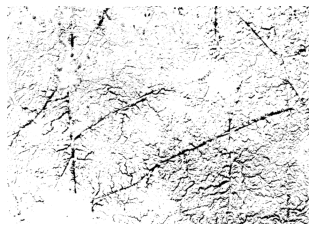

In [40]:
# Sauvola
thresholded = threshold_sauvola(grayscale, window_size=91, k=0.5)
binarized = grayscale > thresholded
evaluate_segmentation(binarized, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binarized, cmap='gray')

### Sauvola+NLM

mIoU: 0.9171837810193403
SSIM: 0.8530853431794728
F1: 0.9568031923696811
PSNR: 59.13266282046965


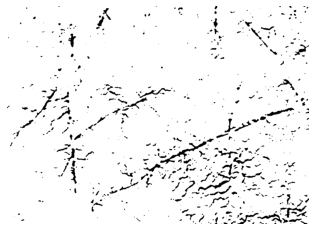

In [47]:
# Non local means denoise on Sauvola segmentation
denoise = cv2.fastNlMeansDenoising(np.asarray(binarized, dtype=np.uint8) ,None,10,7,21)
evaluate_segmentation(denoise > 0, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(denoise, cmap='gray')

### Sauvola+Graph Cut

mIoU: 0.9132950059939375
SSIM: 0.8311854180237956
F1: 0.9546828932629655
PSNR: 58.97928949834542


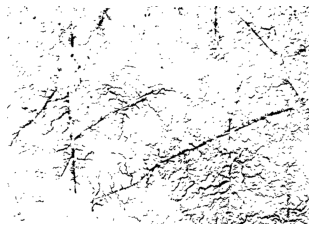

In [48]:
img_denoised = graph_cut(binarized, 500)
evaluate_segmentation(img_denoised > 0, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_denoised, cmap='gray')

### Phansalkar

In [ ]:
# Phansalkar
thresholded = threshold_phansalkar(grayscale, window_size=91, k=0.25, p=3, q=10)
binarized = grayscale > thresholded
evaluate_segmentation(binarized, ground_truth)
# plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binarized, cmap='gray')

### Adaptive local

mIoU: 0.56956095774783
SSIM: 0.19876461812448035
F1: 0.725758314688326
PSNR: 52.20571561621901


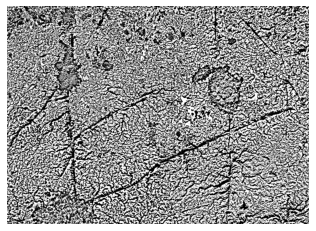

In [52]:
# Local
thresholded = threshold_local(grayscale, block_size=91)
binarized = grayscale > thresholded
evaluate_segmentation(binarized, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binarized, cmap='gray')

### Niblack

mIoU: 0.6512061097661342
SSIM: 0.2978821155987931
F1: 0.7887641717342807
PSNR: 53.112090747442465


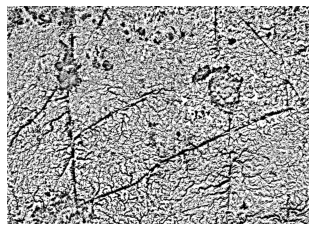

In [53]:
# niblack
thresholded = threshold_niblack(grayscale, window_size=91)
binarized = grayscale > thresholded
evaluate_segmentation(binarized, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binarized, cmap='gray')

### Otsu

mIoU: 0.6973427074754077
SSIM: 0.40844634693910575
F1: 0.8216875760023981
PSNR: 53.752615314285734


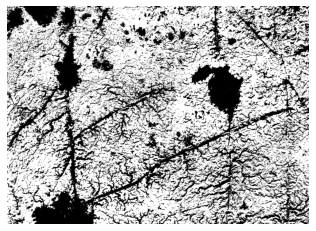

In [54]:
# Otsu
thresholded = threshold_otsu(grayscale)
binarized = grayscale > thresholded
evaluate_segmentation(binarized, ground_truth)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binarized, cmap='gray')

## Testing parameters on Sauvola thresholding

In [ ]:
k = [0.2, 0.5, 0.8]
R = [112, 128, 144, 176]
figs, axs = plt.subplots(np.size(k), np.size(R), figsize=(20,20))

for i in range(np.size(k)):
  for j in range(np.size(R)):
    thresholded = threshold_sauvola(grayscale, 91, k[i], R[j])
    axs[i, j].imshow(grayscale > thresholded, cmap='gray')
    axs[i, j].get_xaxis().set_visible(False)
    axs[i, j].get_yaxis().set_visible(False)

# Fracture characterization and DFN from Sauvola+NLM

In [57]:
skeleton = skeletonize(1-denoise)
lines = line_detection(skeleton*255)

D:\Conda_envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


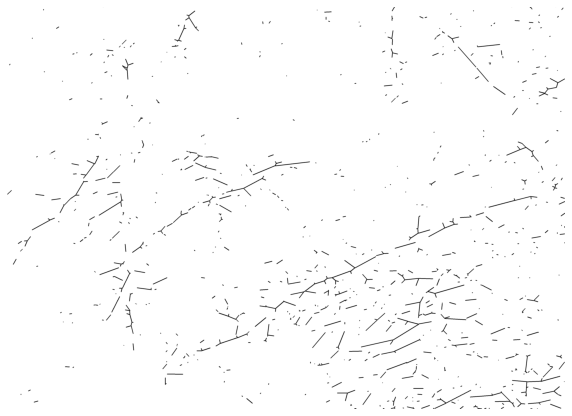

In [58]:
output = np.full((np.shape(image)[0], np.shape(image)[1]), 255, dtype=np.uint8)
output = print_lines(output, np.reshape(lines, (np.shape(lines)[0], 1, 4)), [0])
save_image(output, 'delineaments.tif', dataset.crs, dataset.transform)
# save_shapefile('delineaments', lines, angles, dataset)
# from rasterio.plot import show
# show(output, transform=dataset.transform)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output, cmap='gray')

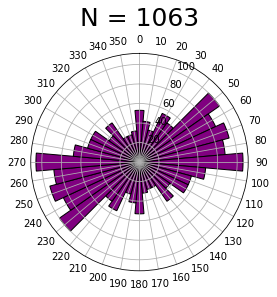

In [59]:
angles = get_line_angles(lines)
rosechart(angles[:, 0], angles[:, 1])

In [68]:
window_size = utm_distance_to_pixel(dataset, 5)
data = compute_p_statistics(lines, grayscale, window_size)

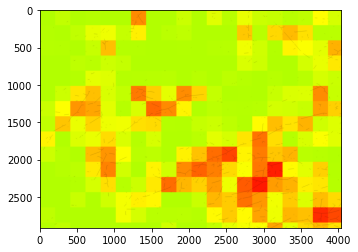

In [69]:
image = np.full((np.shape(grayscale)[0], np.shape(grayscale)[1], 3), 255, dtype=np.uint8)
image = draw_intensity_map(data, image, mode='raster', index='intensity', lines=lines)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

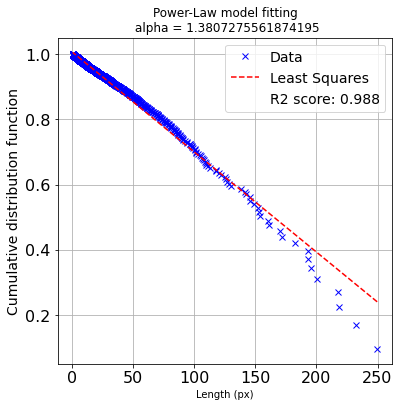

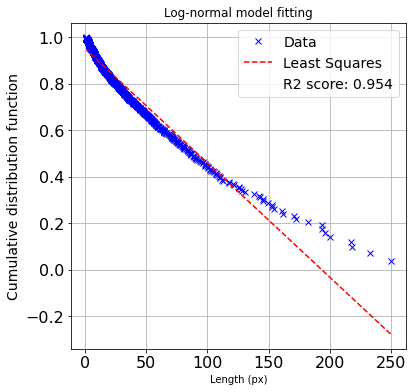

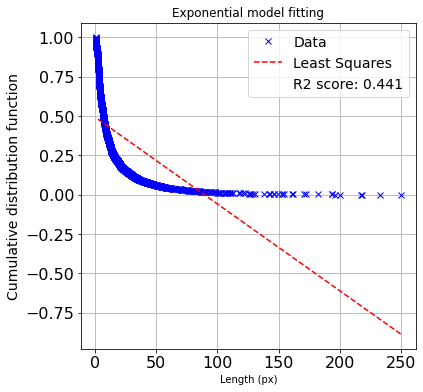

In [29]:
# Set N-S (0-30 e 160 a 180) (?0)
# set1 = np.where((segm_group_angles[:, 0] <= 20) | (segm_group_angles[:, 0] > 150),
#          segm_group_angles[:, 0], None)
set1 = angles
# set1 = set1[set1 != np.array(None)]
# aux = plt.hist(set1[:, 1], bins=147, cumulative=True)

# Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting, alpha = 1.2',  'Length (m)', alpha=1.2)
alpha1 = compute_fractal_dimension(set1[:, 1])
Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting\n alpha = '+ str(alpha1),  'Length (px)', alpha = alpha1)
# Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting, alpha = 2.2',  'Length (m)', alpha=2.2)
Y = probability_plot(set1[:, 1], 'lognormal', 'Log-normal model fitting', 'Length (px)')
Y = probability_plot(set1[:, 1], 'exponential', 'Exponential model fitting', 'Length (px)', A = np.size(set1[:, 1])/(np.shape(grayscale)[0]*np.shape(grayscale)[1]))

# Merging UAV acquisitions for fracture characterization

## Loading images

D:\Conda_envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


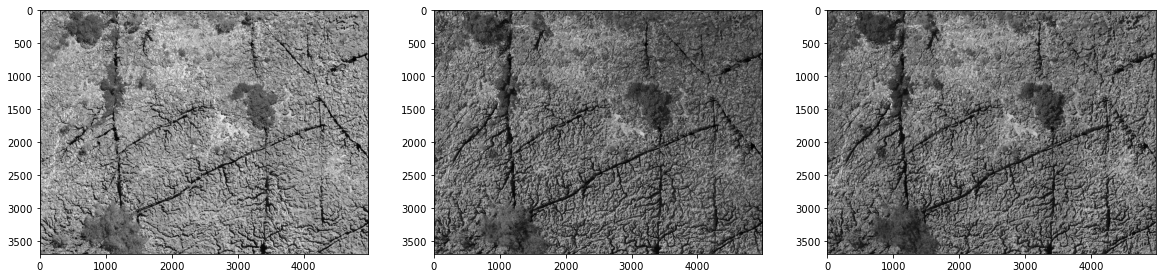

In [79]:
# image0 = cv2.imread("Aligned/local 2/Mavik_manha_recorte.tif")
image0, dataset0 = load_image("Aligned/local 2/Mavik_manha_recorte.tif", 1)
grayscale0 = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY)

# image1 = cv2.imread("Aligned/local 2/Mavik_tarde_recorte.tif")
image1, dataset1 = load_image("Aligned/local 2/Mavik_tarde_recorte.tif", 1)
grayscale1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2, dataset2 = load_image("Aligned/local 2/Phantom_tarde_recorte.tif", 1)
grayscale2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

grayscale0 = cv2.resize(grayscale0, (np.shape(image1)[1], np.shape(image1)[0]))
grayscale2 = cv2.resize(grayscale2, (np.shape(image1)[1], np.shape(image1)[0]))

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(grayscale0, cmap='gray')
axs[1].imshow(grayscale1, cmap='gray')
axs[2].imshow(grayscale2, cmap='gray')
fig.show()

## Segmenting images with Sauvola+NLM

D:\Conda_envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


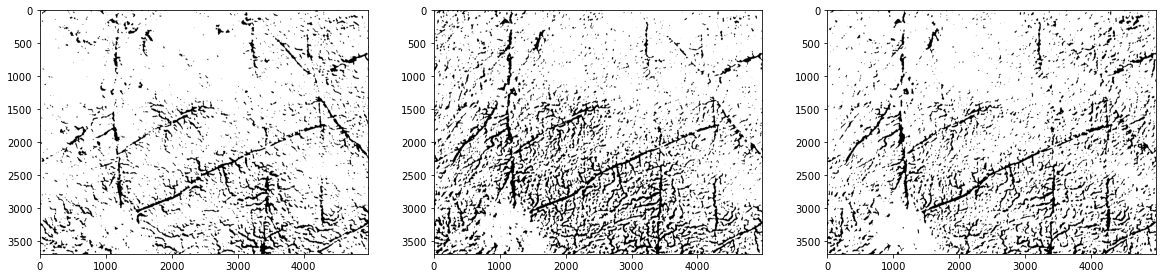

In [80]:
thresholded0 = threshold_sauvola(grayscale0, window_size=91, k=0.5)
binarized0 = grayscale0 > thresholded0
denoise0 = cv2.fastNlMeansDenoising(np.asarray(binarized0, dtype=np.uint8) ,None,10,7,21)

thresholded1 = threshold_sauvola(grayscale1, window_size=91, k=0.5)
binarized1 = grayscale1 > thresholded1
denoise1 = cv2.fastNlMeansDenoising(np.asarray(binarized1, dtype=np.uint8) ,None,10,7,21)

thresholded2 = threshold_sauvola(grayscale2, window_size=91, k=0.5)
binarized2 = grayscale2 > thresholded2
denoise2 = cv2.fastNlMeansDenoising(np.asarray(binarized2, dtype=np.uint8) ,None,10,7,21)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(denoise0, cmap='gray')
axs[1].imshow(denoise1, cmap='gray')
axs[2].imshow(denoise2, cmap='gray')
fig.show()

## Combining noisy segmentations

True

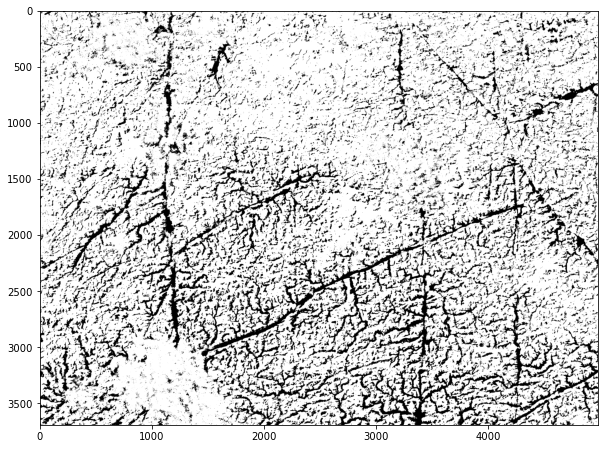

In [81]:
binarized0 = np.asarray(binarized0, dtype=np.uint8)
binarized1 = np.asarray(binarized1, dtype=np.uint8)
binarized2 = np.asarray(binarized2, dtype=np.uint8)

plt.figure(figsize=(10,10))
combined = (1-cv2.resize(binarized0, (np.shape(binarized1)[1], np.shape(binarized1)[0])))+(1-binarized1) + (1-cv2.resize(binarized2, (np.shape(binarized1)[1], np.shape(binarized1)[0])))
combined = np.where(combined > 1, 0, 1)
combined = np.asarray(combined*255, dtype=np.uint8)
kernel = np.ones((5,5),np.uint8)
# combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
plt.imshow(combined, cmap='gray')
cv2.imwrite("combined_noisy.png", combined)

## Combining Sauvola+NLM segmentations

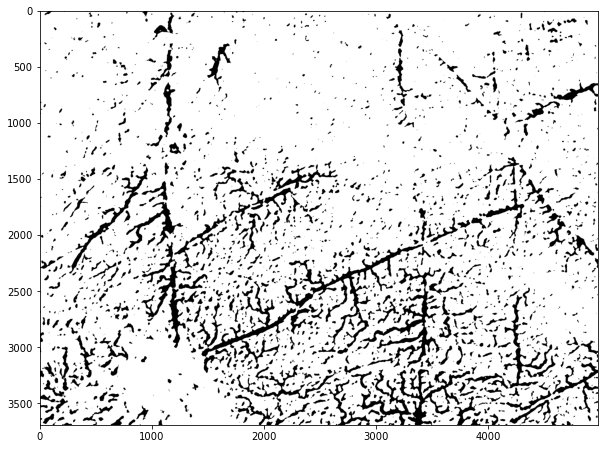

In [73]:
plt.figure(figsize=(10,10))
combined = (1-cv2.resize(denoise0, (np.shape(denoise1)[1], np.shape(denoise1)[0])))+(1-denoise1) + (1-cv2.resize(denoise2, (np.shape(denoise1)[1], np.shape(denoise1)[0])))
combined = np.where(combined > 1, 0, 1)
plt.imshow(combined, cmap='gray')

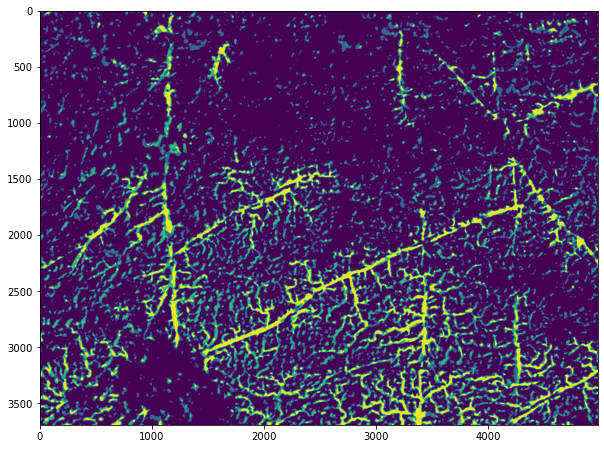

In [82]:
plt.figure(figsize=(10,10))
# denoised_diff = (1-cv2.resize(denoise0, (np.shape(denoise1)[1], np.shape(denoise1)[0])))+(1-denoise1) + (1-cv2.resize(denoise2, (np.shape(denoise1)[1], np.shape(denoise1)[0])))
denoised_diff = (1-denoise0) + (1-denoise1) + (1-denoise2)
plt.imshow(denoised_diff, cmap='viridis')

In [83]:
# inverted = 255 - binarized
skeleton0 = skeletonize(1-denoise0)
skeleton1 = skeletonize(1-denoise1)
skeleton2 = skeletonize(1-denoise2)

#fig, axs = plt.subplots(1, 2, figsize=(20,10))
#axs[0].imshow(1-skeleton0, cmap='gray')
#axs[1].imshow(1-skeleton1, cmap='gray')
#fig.show()

## Morning Mavik UAV flight fracture characterization

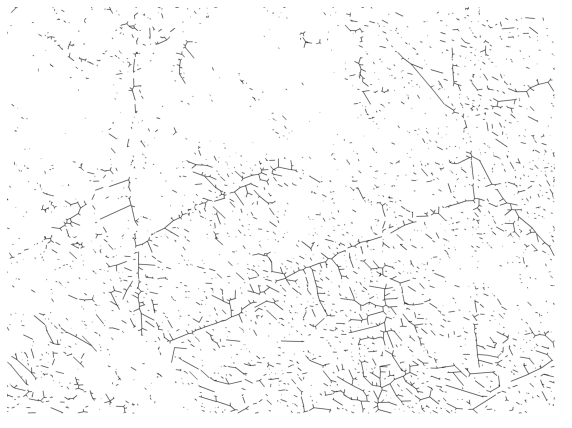

In [84]:
lines0 = line_detection(skeleton0*255)
output0 = np.full((np.shape(image0)[0], np.shape(image0)[1]), 255, dtype=np.uint8)
output0 = print_lines(output0, np.reshape(lines0, (np.shape(lines0)[0], 1, 4)), [0])
save_image(output0, 'delineaments0.tif', dataset0.crs, dataset0.transform)
# save_shapefile('delineaments', lines, angles, dataset)
# from rasterio.plot import show
# show(output, transform=dataset.transform)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output0, cmap='gray')

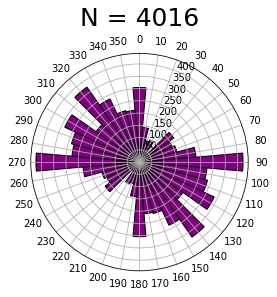

In [85]:
angles0 = get_line_angles(lines0)
rosechart(angles0[:, 0], angles0[:, 1])

## Afternoon Phantom P4 UAV flight fracture characterization

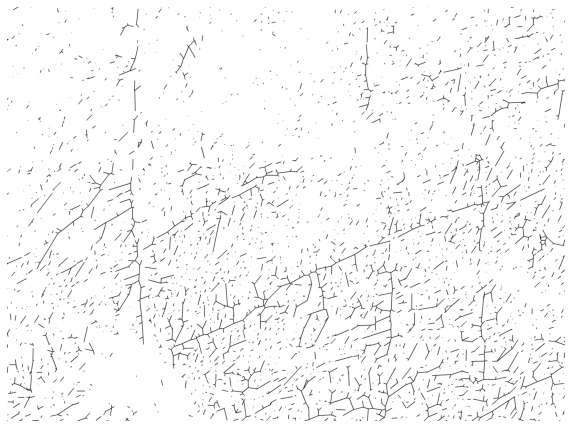

In [89]:
lines2 = line_detection(skeleton2*255)
output2 = np.full((np.shape(image1)[0], np.shape(image1)[1]), 255, dtype=np.uint8)
output2 = print_lines(output2, np.reshape(lines2, (np.shape(lines2)[0], 1, 4)), [0])
save_image(output2, 'delineaments2.tif', dataset2.crs, dataset2.transform)
# save_shapefile('delineaments', lines, angles, dataset)
# from rasterio.plot import show
# show(output, transform=dataset.transform)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output2, cmap='gray')

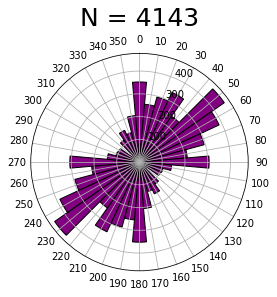

In [90]:
angles2 = get_line_angles(lines2)
rosechart(angles2[:, 0], angles2[:, 1])

## Afternoon Mavik UAV flight fracture characterization

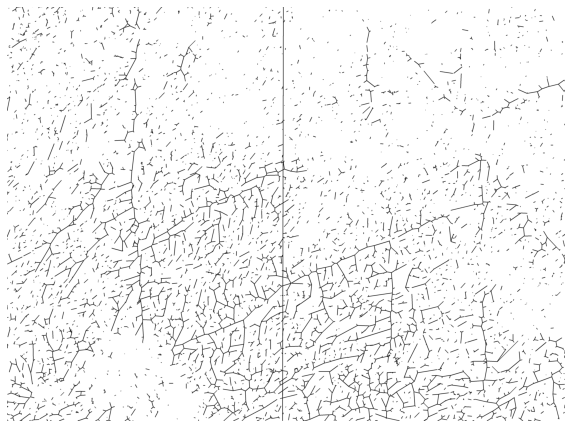

In [87]:
lines1 = line_detection(skeleton1*255)
output1 = np.full((np.shape(image1)[0], np.shape(image1)[1]), 255, dtype=np.uint8)
output1 = print_lines(output1, np.reshape(lines1, (np.shape(lines1)[0], 1, 4)), [0])
save_image(output0, 'delineaments1.tif', dataset1.crs, dataset1.transform)
# save_shapefile('delineaments', lines, angles, dataset)
# from rasterio.plot import show
# show(output, transform=dataset.transform)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output1, cmap='gray')

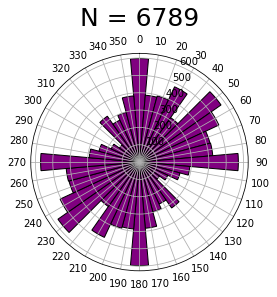

In [88]:
angles1 = get_line_angles(lines1)
rosechart(angles1[:, 0], angles1[:, 1])

In [38]:
save_shapefile('delineaments0', lines0, angles0, dataset0)
save_shapefile('delineaments1', lines1, angles1, dataset1)

## Combined UAV flight fracture characterization

C:\Users\adeju\anaconda3\envs\tensorflow-cpu\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


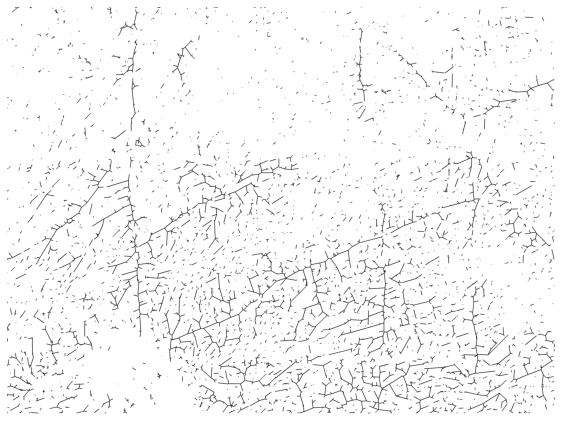

In [34]:
skeleton_diff = skeletonize(1-combined)
lines_diff = line_detection(skeleton_diff*255)
output_diff = np.full((np.shape(image0)[0], np.shape(image0)[1]), 255, dtype=np.uint8)
output_diff = print_lines(output_diff, np.reshape(lines_diff, (np.shape(lines_diff)[0], 1, 4)), [0])
save_image(output_diff, 'delineaments_combined.tif', dataset.crs, dataset.transform)
# save_shapefile('delineaments', lines, angles, dataset)
# from rasterio.plot import show
# show(output, transform=dataset.transform)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output_diff, cmap='gray')

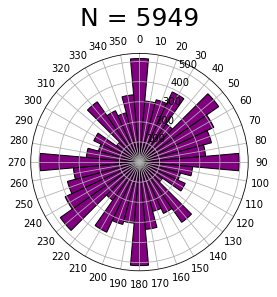

In [35]:
angles_diff = get_line_angles(lines_diff)
min_size = 0
rosechart(angles_diff[np.where(angles_diff[:, 1] > min_size), 0], angles_diff[np.where(angles_diff[:, 1] > min_size), 1])

In [94]:
save_shapefile('delineaments_comb', lines_diff, angles_diff, dataset1)

In [96]:
#np.savetxt('lines0.csv', lines0, delimiter=',')
#np.savetxt('lines1.csv', lines1, delimiter=',')
np.savetxt('lines2.csv', lines2, delimiter=',')
np.savetxt('lines_comb.csv', lines_diff, delimiter=',')

1.4208603102885498


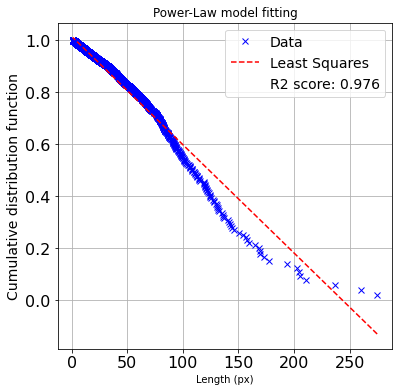

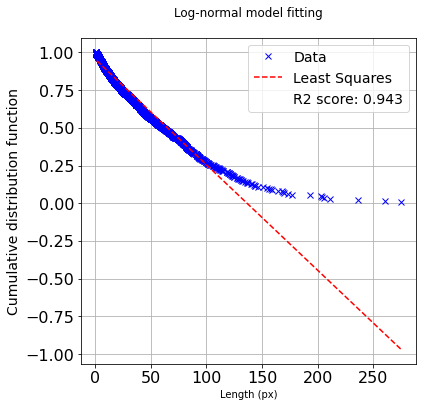

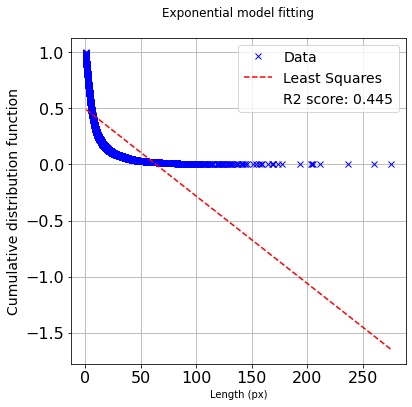

In [36]:
set1 = angles_diff[angles_diff[:, 1] > 0]
# set1 = set1[set1 != np.array(None)]
# aux = plt.hist(set1[:, 1], bins=147, cumulative=True)

# Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting, alpha = 1.2',  'Length (m)', alpha=1.2)
alpha1 = compute_fractal_dimension(set1[:, 1])
print(alpha1)
Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting',  'Length (px)', alpha = alpha1)
Y = probability_plot(set1[:, 1], 'lognormal', 'Log-normal model fitting\n',  'Length (px)')
Y = probability_plot(set1[:, 1], 'exponential', 'Exponential model fitting\n',  'Length (px)', A = 2/np.pi)



## Aperture estimation with Medial Axis Transform - MAT

In [37]:
from skimage.morphology import medial_axis

inverted = 1-combined
skel, distance = medial_axis(inverted, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

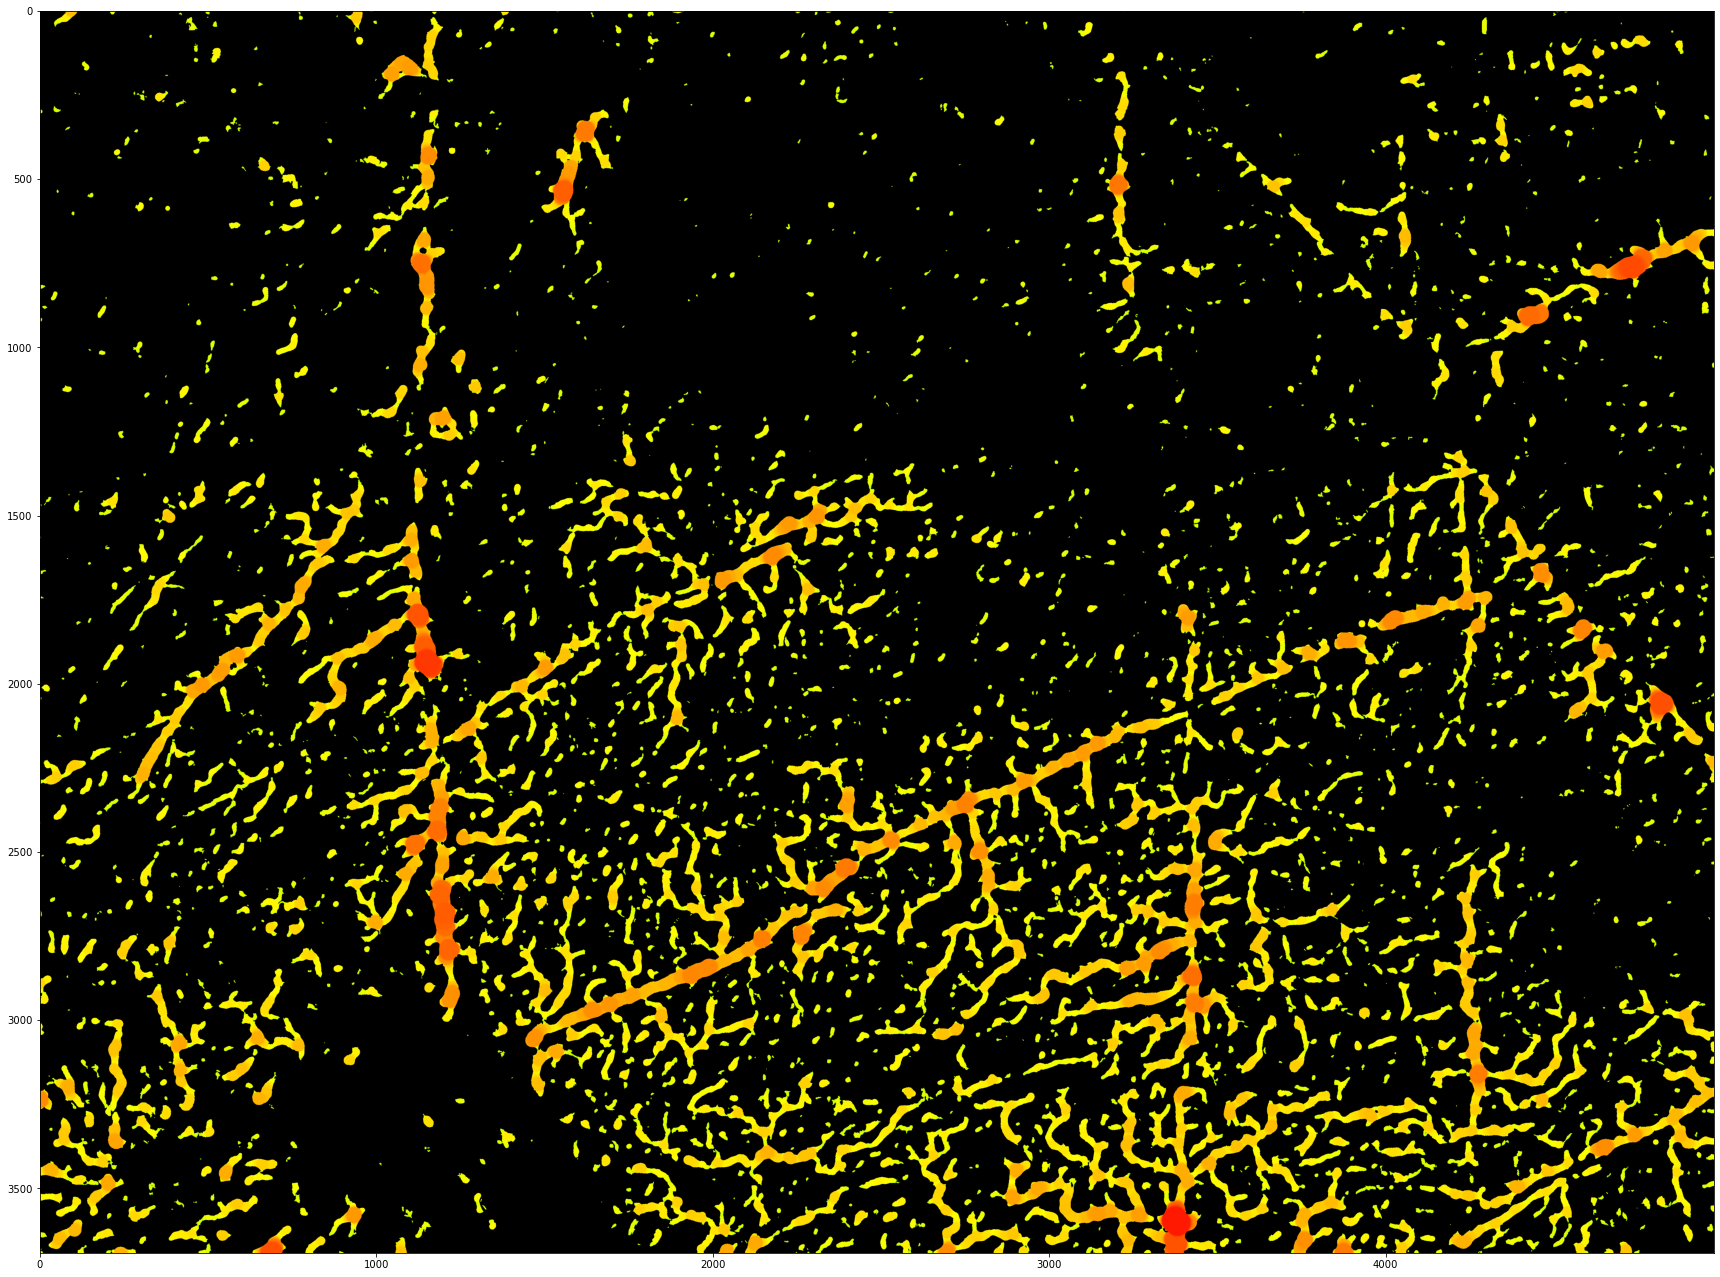

In [38]:
max_value = np.max(dist_on_skel)
x, y = np.where(dist_on_skel > 0)
aperture = np.full((np.shape(image1)[0], np.shape(image1)[1], 3), 0, dtype=np.uint8)

values = dist_on_skel[np.where(dist_on_skel > 0)]

x = x[np.argsort(values)]
y = y[np.argsort(values)]

for i in range(0, np.size(x)):
    color = colorsys.hsv_to_rgb((0.45+dist_on_skel[x[i], y[i]]/max_value*0.20), 1, 1)
    color = (int(color[2]*255), int(color[1]*255), int(color[0]* 255))
    aperture = cv2.circle(aperture, (y[i], x[i]), int(dist_on_skel[x[i], y[i]]), color, -1)
plt.figure(figsize=(30,30))
#plt.contourf(list(range(0, np.shape(dist_on_skel)[1])), list(range(0, np.shape(dist_on_skel)[0])), dist_on_skel*5, 3, cmap='inferno', origin='image')
plt.imshow(aperture)

## Aperture distribution estimation

1.5587933872560522


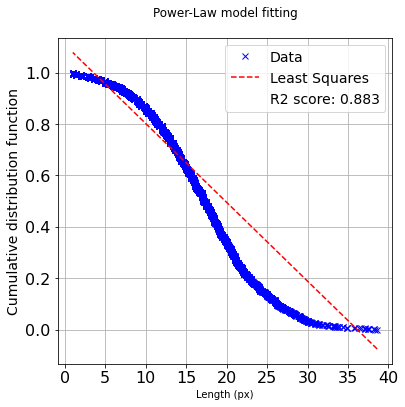

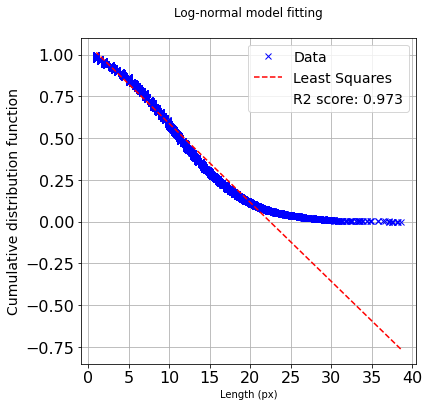

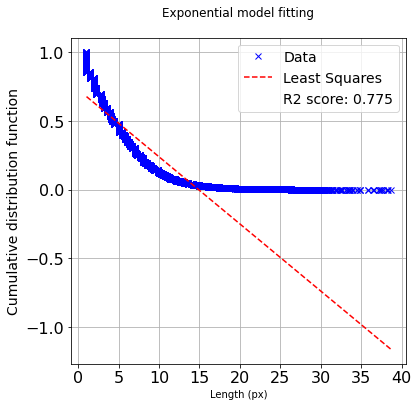

In [40]:
aperture_data = dist_on_skel[np.where(dist_on_skel > 0)]

aperture_data = np.random.choice(aperture_data, int(np.size(aperture_data)/3))

# set1 = set1[set1 != np.array(None)]
# aux = plt.hist(set1[:, 1], bins=147, cumulative=True)

# Y = probability_plot(set1[:, 1], 'power', 'Power-Law model fitting, alpha = 1.2',  'Length (m)', alpha=1.2)
alpha1 = compute_fractal_dimension(aperture_data)
print(alpha1)
Y = probability_plot(aperture_data, 'power', 'Power-Law model fitting\n',  'Length (px)', alpha = alpha1)
Y = probability_plot(aperture_data, 'lognormal', 'Log-normal model fitting\n',  'Length (px)')
Y = probability_plot(aperture_data, 'exponential', 'Exponential model fitting\n',  'Length (px)', A = 2/np.pi)

## Fracture intensity estimation

In [ ]:
window_size = utm_distance_to_pixel(dataset, 5)
data = compute_p_statistics(lines_diff, grayscale, window_size)

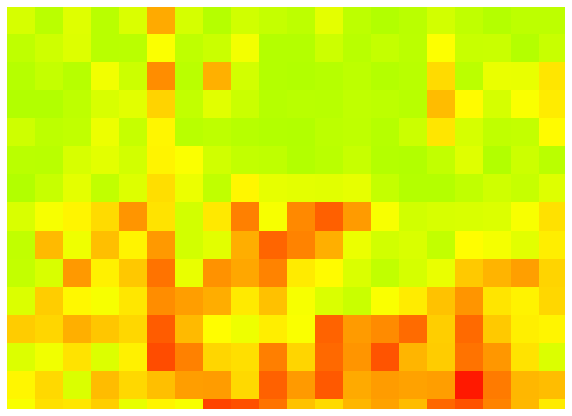

In [199]:
canvas = np.full((np.shape(grayscale)[0], np.shape(grayscale)[1], 3), 255, dtype=np.uint8)
canvas = draw_intensity_map(data, canvas, mode='raster', index='intensity')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))

## Interpolated data

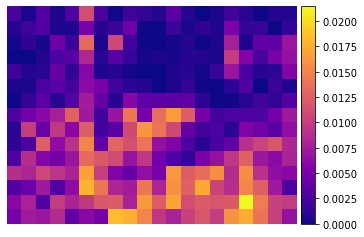

In [205]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
im = ax.imshow(np.reshape(data[:, 4], (20,15)).T, cmap='plasma')


plt.axis('off')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

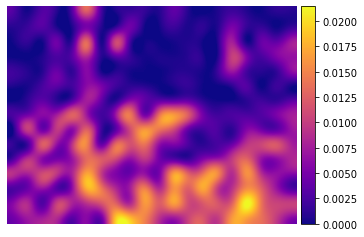

In [204]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
im = ax.imshow(np.reshape(data[:, 4], (20,15)).T, cmap='plasma', interpolation='lanczos')


plt.axis('off')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [225]:
print(np.mean(data[:,5]))
print(np.std(data[:, 4]))

115.17547131417396
0.004961043283582567


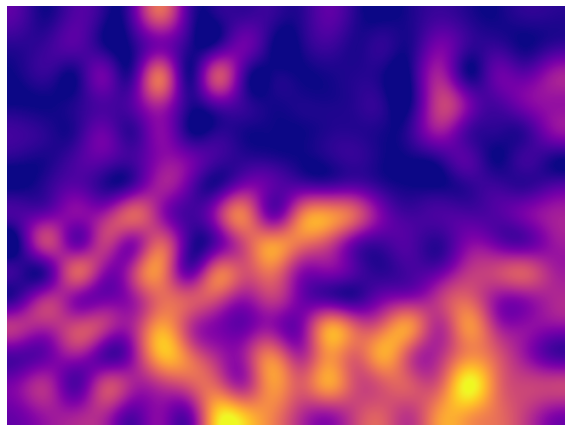

In [195]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(np.reshape(data[:, 4], (20,15)).T, cmap='plasma', interpolation='lanczos')